# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
from rapidfuzz import process, fuzz
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
import hdbscan

# Load Data

Statrting off I tried to load the data but it wasn't able to load due to some issues:
* The date column has a strange encoding having +AC0- instead of  - 
* The Last column has an issue that it has multiple values not marked as ' " " ' instead has +ACI- encoding

In [89]:
# Clean encoding problems in the CSV file
with open(r'C:\Users\walee\Downloads\bank_customer_transactions.csv', 'r', encoding='utf-8') as original_file:
    with open(r'C:\Users\walee\Downloads\bank_customer_transactions_cleaned.csv', 'w', encoding='utf-8') as cleaned_file:
        for line in original_file:
            cleaned_line = (
                line.replace('+AC0-', '-')     
                    .replace('+ACI-', '"')      
            )
            cleaned_file.write(cleaned_line)

In [4]:
df = pd.read_csv(r'C:\Users\walee\Downloads\bank_customer_transactions_cleaned.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),OwnedProducts
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,"credit card, loans, savings"
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2/8/16,141858,27999.0,tds
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2/8/16,142712,459.0,"loans, savings"
3,T4,C5342380,2073-09-14,F,MUMBAI,866503.21,2/8/16,142714,2060.0,"long term investment, savings"
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,"loans, savings"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 10 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
 9   OwnedProducts            1028087 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 80.0+ MB


In [5]:
df.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1.046198e+06,1.048567e+06,1.048567e+06
mean,1.154035e+05,1.570875e+05,1.574335e+03
std,8.464854e+05,5.126185e+04,6.574743e+03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.721760e+03,1.240300e+05,1.610000e+02
50%,1.679218e+04,1.642260e+05,4.590300e+02
75%,5.765736e+04,2.000100e+05,1.200000e+03
max,1.150355e+08,2.359590e+05,1.560035e+06


In [6]:
#check for missing values
df.isnull().sum()

TransactionID                  0
CustomerID                     0
CustomerDOB                 3397
CustGender                  1100
CustLocation                 151
CustAccountBalance          2369
TransactionDate                0
TransactionTime                0
TransactionAmount (INR)        0
OwnedProducts              20480
dtype: int64

In [7]:
#check for duplicates
df.duplicated().sum()

0

* There are problems related to date columns
* Wide ranges of values in columns

# EDA

C:\Users\walee\AppData\Local\Temp\ipykernel_11892\1492674311.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CustGender', data=df, palette='Set2')


Text(0.5, 1.0, 'Distribution of CustGender')

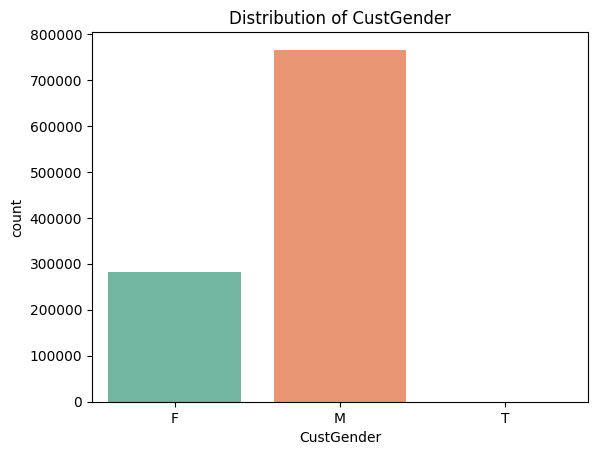

In [8]:
#plot the distribution of the target variable
sns.countplot(x='CustGender', data=df, palette='Set2')
plt.title('Distribution of CustGender')

Text(0.5, 1.0, 'Distribution of CustGender')

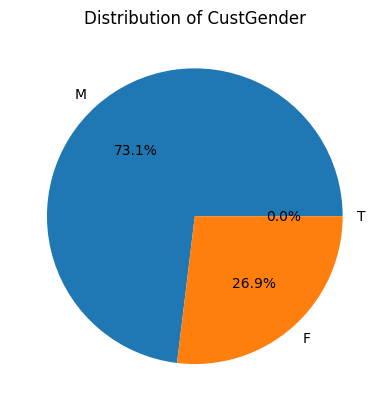

In [290]:
#pie chart of the target variable
plt.pie(df['CustGender'].value_counts(), labels=df['CustGender'].value_counts().index, autopct='%1.1f%%',)
plt.title('Distribution of CustGender')

This column makes us concluse that:
* There is an imbalance in the no of males compared to the no of females
* There is wrong entry of value T instead of M and F


Text(0.5, 1.0, 'Customer Account Balance')

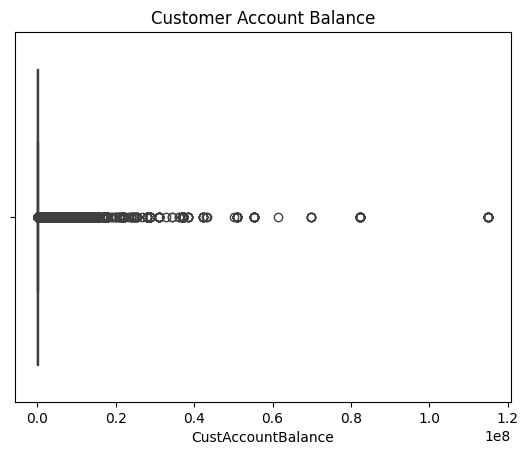

In [291]:
#Plot customer account balance using boxplot
sns.boxplot(x='CustAccountBalance', data=df)
plt.title('Customer Account Balance')

Text(0.5, 1.0, 'Customer Account Balance')

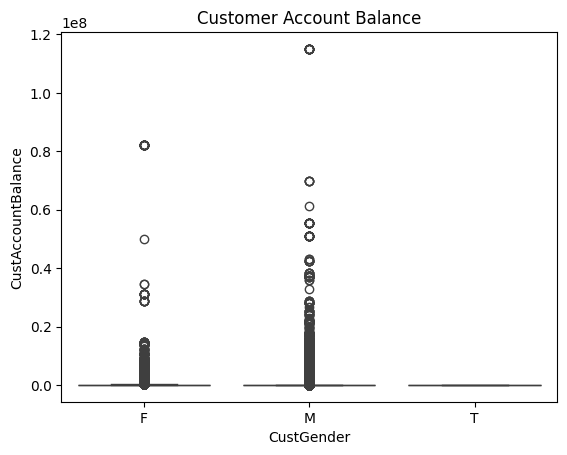

In [292]:
sns.boxplot(x='CustGender', y='CustAccountBalance', data=df)
plt.title('Customer Account Balance')

Accorfing to these results we can conclude that :
* There is a a huge outliers in this column due to the variation tn customer's balances
* The outliers in the Male gender is larger maybe this is also due to the data imbalance

Text(0.5, 1.0, 'Transaction Amount')

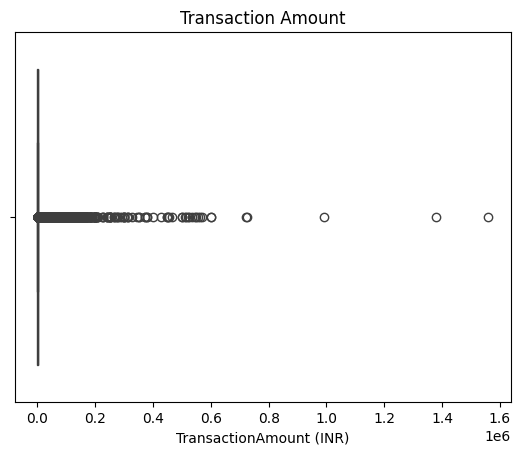

In [293]:
#Transaction ampunt boxplot
sns.boxplot(x='TransactionAmount (INR)', data=df)
plt.title('Transaction Amount')

Text(0.5, 1.0, 'Customer TransactionAmount (INR)')

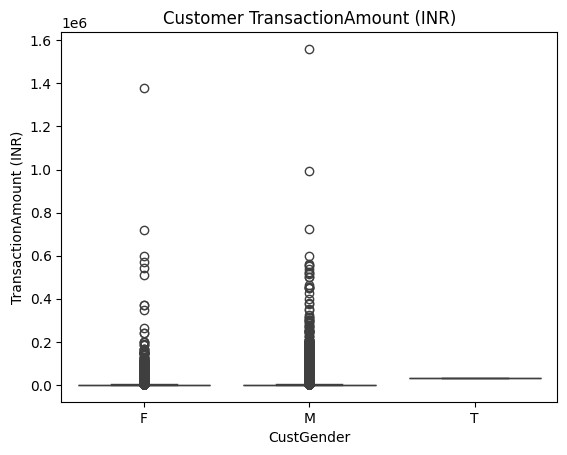

In [294]:
sns.boxplot(x='CustGender', y='TransactionAmount (INR)', data=df)
plt.title('Customer TransactionAmount (INR)')

Here we can say the same thing as probablt the amount of transactions related somehow with the balance of customer

Text(0.5, 1.0, 'Correlation Matrix')

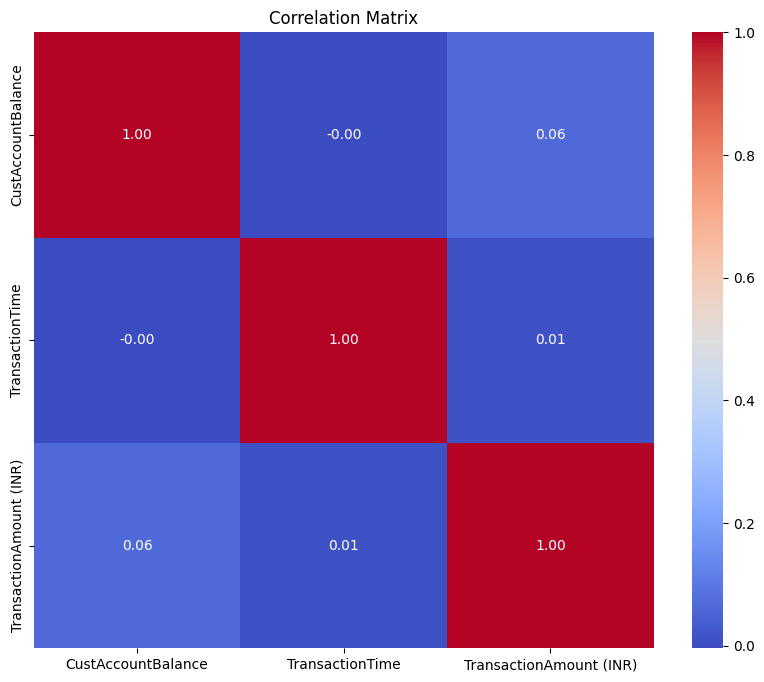

In [295]:
#check correlation between numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')

Text(0.5, 1.0, 'Transaction Amount vs Account Balance')

C:\Users\walee\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\walee\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


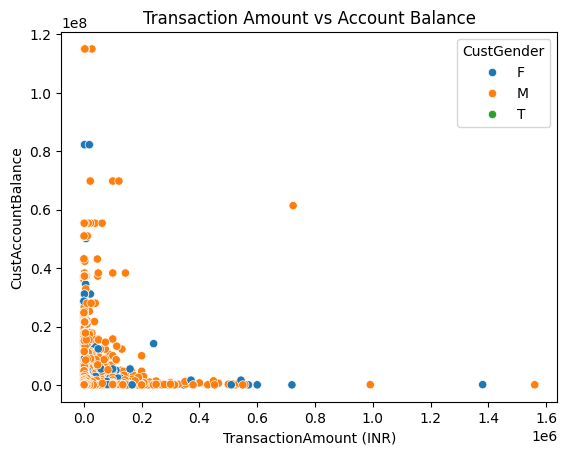

In [296]:
#Transaction amount and account balance correlation
sns.scatterplot(x='TransactionAmount (INR)', y='CustAccountBalance', data=df, hue='CustGender')
plt.title('Transaction Amount vs Account Balance')

This plot can indicate that:
* The majority of customers have low transaction amounts and low account balances
* There are a few outliers with very high transaction amounts

# Data Cleaning and Preprocessing

After replacing certain values that was encoding related issue
Let's move deeper in cleaning data.
We will take each column seperatly

Transaction ID column

In [9]:
df.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)', 'OwnedProducts'],
      dtype='object')

In [ ]:
df.drop(columns=['TransactionID'], inplace=True)

In [299]:
df.head()

,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),OwnedProducts
0,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0,"credit card, loans, savings"
1,C2142763,2057-04-04,M,JHAJJAR,2270.69,2/8/16,141858,27999.0,tds
2,C4417068,1996-11-26,F,MUMBAI,17874.44,2/8/16,142712,459.0,"loans, savings"
3,C5342380,2073-09-14,F,MUMBAI,866503.21,2/8/16,142714,2060.0,"long term investment, savings"
4,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,"loans, savings"


Customer ID column

In [12]:
df['CustomerID'].head()

0    C5841053
1    C2142763
2    C4417068
3    C5342380
4    C9031234
Name: CustomerID, dtype: object

In [14]:
df['CustomerID'].nunique()

884265

In [302]:
df['CustomerID'].isnull().sum()


0

There are 884264 customer who made around million transacrion in this time span

Date columns

In [4]:
#I have an issue in the dates columns that beside that they are both objects datatypes
#They are not in the same format
df[['CustomerDOB' , 'TransactionDate']].head(10)

,CustomerDOB,TransactionDate
0,1994-01-10,2/8/16
1,2057-04-04,2/8/16
2,1996-11-26,2/8/16
3,2073-09-14,2/8/16
4,1988-03-24,2/8/16
5,2072-10-08,2/8/16
6,1992-01-26,2/8/16
7,1982-01-27,2/8/16
8,1988-04-19,2/8/16
9,1984-06-22,2/8/16


In [5]:
#TransactionDate I want to convert last part which is year from 16 to 2016
df['TransactionDate'] = df['TransactionDate'].str.replace(r'(\d{2})$', lambda x: '20' + x.group(1), regex=True)

In [6]:
#convert CustomerDOB columns from object to datetime
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format='%Y-%m-%d')

In [7]:
#convert TransactionDate columns from object to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True)

In [8]:
df[['CustomerDOB' , 'TransactionDate']].head(10)

,CustomerDOB,TransactionDate
0,1994-01-10,2016-08-02
1,2057-04-04,2016-08-02
2,1996-11-26,2016-08-02
3,2073-09-14,2016-08-02
4,1988-03-24,2016-08-02
5,2072-10-08,2016-08-02
6,1992-01-26,2016-08-02
7,1982-01-27,2016-08-02
8,1988-04-19,2016-08-02
9,1984-06-22,2016-08-02


In [9]:
df[['CustomerDOB' , 'TransactionDate']].dtypes

CustomerDOB        datetime64[ns]
TransactionDate    datetime64[ns]
dtype: object

In [9]:
#check null 
df[['CustomerDOB' , 'TransactionDate']].isnull().sum()

CustomerDOB        3397
TransactionDate       0
dtype: int64

In [10]:
#use CustomerDOB to calculate the age of the customer
df['CustomerAge'] = (pd.to_datetime('today') - df['CustomerDOB']).dt.days // 365

In [10]:
df['CustomerAge'].describe()

count    1.045170e+06
mean     3.949051e+01
std      5.077492e+01
min     -5.000000e+01
25%      3.200000e+01
50%      3.600000e+01
75%      4.100000e+01
max      2.250000e+02
Name: CustomerAge, dtype: float64

Text(0.5, 1.0, 'Distribution of Customer Age')

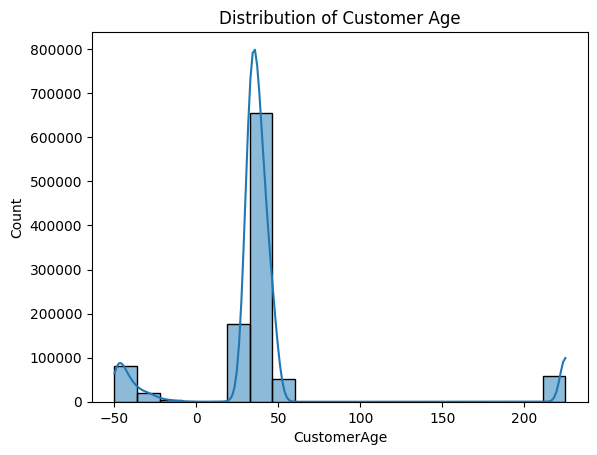

In [312]:
#check distribution of the age
sns.histplot(df['CustomerAge'], bins=20, kde=True)
plt.title('Distribution of Customer Age')

We Can see here from that distribution that there are alot of outliers and unreasonable values such as  : 
* age = -50 or 200 years so we will try to limlit this to a certain reasonable values.

In [11]:
#make the age range between 18 and 100 and drop the rest of the ages
df = df[(df['CustomerAge'] >= 18) & (df['CustomerAge'] <= 100)]

In [25]:
df['CustomerAge'].describe()

count    882432.000000
mean         37.061363
std           5.174619
min          18.000000
25%          33.000000
50%          36.000000
75%          41.000000
max          50.000000
Name: CustomerAge, dtype: float64

Text(0.5, 1.0, 'Distribution of Customer Age')

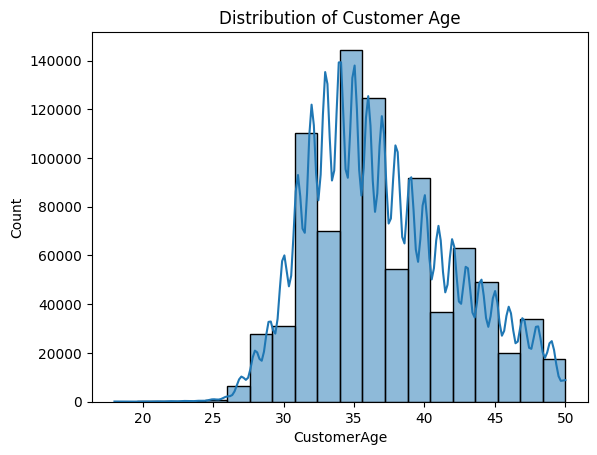

In [315]:
#check distribution of the age after edit
sns.histplot(df['CustomerAge'], bins=20, kde=True)
plt.title('Distribution of Customer Age')

In [26]:
df['CustomerAge'].isnull().sum()

0

In [12]:
#create columns for the month and year of the transaction
df['TransactionMonth'] = df['TransactionDate'].dt.month
df['TransactionYear'] = df['TransactionDate'].dt.year
df['TransactionMonth'].head()

0    8
2    8
4    8
6    8
7    8
Name: TransactionMonth, dtype: int32

In [318]:
df['TransactionYear'].head()

0    2016
2    2016
4    2016
6    2016
7    2016
Name: TransactionYear, dtype: int32

Customer Gender Column

In [319]:
df.columns

Index(['CustomerID', 'CustomerDOB', 'CustGender', 'CustLocation',
       'CustAccountBalance', 'TransactionDate', 'TransactionTime',
       'TransactionAmount (INR)', 'OwnedProducts', 'CustomerAge',
       'TransactionMonth', 'TransactionYear'],
      dtype='object')

In [16]:
df['CustGender'].value_counts()

CustGender
M    637665
F    244754
Name: count, dtype: int64

In [321]:
#drop T values in CustGender column
df = df[df['CustGender'] != 'T']

In [13]:
df['CustGender'].value_counts()

CustGender
M    637665
F    244754
Name: count, dtype: int64

In [14]:
# Check how many unique DOBs and Genders exist per customer
dob_conflicts = df.groupby('CustomerID')['CustomerDOB'].nunique()
gender_conflicts = df.groupby('CustomerID')['CustGender'].nunique()

# If a customer has multiple DOBs or genders, we can consider it a conflict
dob_conflicts = dob_conflicts[dob_conflicts > 1]
gender_conflicts = gender_conflicts[gender_conflicts > 1]

In [15]:
df[df['CustomerID'].isin(dob_conflicts.index) | df['CustomerID'].isin(gender_conflicts.index)]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),OwnedProducts,CustomerAge,TransactionMonth,TransactionYear
6,T7,C7126560,1992-01-26,F,MUMBAI,973.46,2016-08-02,173806,566.0,"loans, retirement plan",33.0,8,2016
10,T11,C5430833,1982-07-22,M,MOHALI,48429.49,2016-08-02,204133,259.0,"credit card, savings",42.0,8,2016
27,T28,C2416848,1993-04-01,M,CHENNAI,20986.66,2016-08-03,160544,2235.0,"credit card, loans, savings",32.0,8,2016
41,T42,C7923455,1992-10-06,M,ANDHERI (EAST) MUMBAI,5810.82,2016-08-03,221111,12.0,"loans, savings",32.0,8,2016
43,T44,C2023055,1993-07-30,M,MUMBAI,10630.88,2016-08-03,222006,421.8,"credit card, loans, retirement plan, savings",31.0,8,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048547,T1048548,C5674116,1996-07-09,M,DELHI,9153.16,2016-09-18,182800,99.0,"loans, savings",28.0,9,2016
1048549,T1048550,C4819452,1990-10-30,F,THANE THANE,1600.14,2016-09-18,184226,1094.0,loans,34.0,9,2016
1048555,T1048556,C2122724,1978-03-20,M,FARIDABAD,436598.03,2016-09-18,185337,5259.0,"cds, long term investment, retirement plan, sa...",47.0,9,2016
1048556,T1048557,C3414578,1990-09-10,F,GURGAON,27592.70,2016-09-18,184932,2000.0,"credit card, loans, savings",34.0,9,2016


In [15]:
#C7126560 
df[df['CustomerID'] == 'C7126560']


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),OwnedProducts,CustomerAge,TransactionMonth,TransactionYear
6,T7,C7126560,1992-01-26,F,MUMBAI,973.46,2016-08-02,173806,566.0,"loans, retirement plan",33.0,8,2016
835789,T835790,C7126560,1988-02-21,M,AURANGABAD,2052.35,2016-09-04,124043,36.0,loans,37.0,9,2016
894830,T894831,C7126560,1993-01-24,M,PANIPAT,12555.81,2016-09-07,122400,19.0,"credit card, loans, savings",32.0,9,2016
967750,T967751,C7126560,1986-09-14,M,PUNE,34829.84,2016-09-10,101907,200.0,"credit card, savings",38.0,9,2016


In [16]:
# Keep only customers with consistent DOB and Gender
valid_customers = set(df.groupby('CustomerID')['CustomerDOB'].nunique().eq(1)[lambda x: x].index) & \
                set(df.groupby('CustomerID')['CustGender'].nunique().eq(1)[lambda x: x].index)

In [65]:
len(valid_customers)

657924

In [17]:
df = df[df['CustomerID'].isin(valid_customers)]

In [66]:
df.shape

(658648, 24)

In [19]:
#check null values
df['CustGender'].isnull().sum()

0

In [18]:
#impute missing values in CustGender column with the mode
df['CustGender'].fillna(df['CustGender'].mode()[0], inplace=True)
df['CustGender'].isnull().sum()

C:\Users\walee\AppData\Local\Temp\ipykernel_13716\3154229586.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CustGender'].fillna(df['CustGender'].mode()[0], inplace=True)


0

In [19]:
# convert categorical variables to numerical variables
#male = 0 , female = 1
df['CustGender'] = df['CustGender'].map({'M': 0, 'F': 1})

In [22]:
df['CustGender'].value_counts()

CustGender
0    476224
1    182519
Name: count, dtype: int64

Customer Location Column

In [334]:
df.columns

Index(['CustomerID', 'CustomerDOB', 'CustGender', 'CustLocation',
       'CustAccountBalance', 'TransactionDate', 'TransactionTime',
       'TransactionAmount (INR)', 'OwnedProducts', 'CustomerAge',
       'TransactionMonth', 'TransactionYear'],
      dtype='object')

In [335]:
df['CustLocation'].head()

0     JAMSHEDPUR
2         MUMBAI
4    NAVI MUMBAI
7         MUMBAI
8        GURGAON
Name: CustLocation, dtype: object

In [336]:
df['CustLocation'].nunique()

7069

In [337]:
#see all unique values in CustLocation column
locations = df['CustLocation'].unique().tolist()
locations

['JAMSHEDPUR',
 'MUMBAI',
 'NAVI MUMBAI',
 'GURGAON',
 'GUNTUR',
 'AHMEDABAD',
 'THANE',
 'PUNE',
 'NO 3 KALYANI NAGAR PUNE',
 'SECUNDERABAD',
 'LUCKNOW',
 'DELHI',
 'GRAM PANCHAYTH HYDERABAD',
 'GHAZIABAD',
 'BANGALORE',
 'CHENNAI',
 'GUWAHATI',
 'DHANBAD',
 'MUKTSAR',
 'SOCORRO',
 'AURANGABAD',
 'KOTA',
 'K V RANGAREDDY',
 'MUZAFFARNAGAR',
 'BURDWAN',
 'LUDHIANA',
 'NOIDA',
 'JAIPUR',
 'HYDERABAD',
 'GODDA',
 'ADIPUR',
 'NEW DELHI',
 'ALLAHABAD',
 'JABALPUR',
 'KASHIPUR',
 'ETAH',
 'KOLKATA',
 'VADODARA',
 'TIRUPUR',
 'NAGO THANE',
 'CHITTO0R',
 'INDORE',
 'OFF CUBBON ROAD BANGALORE',
 'PIMPALI',
 'PUMP HINJEWADI PUNE',
 'MIRABHAYANDER THANE MIRA ROAD',
 'SAHARANPUR',
 'CHANDIGARH',
 'COMPLEX GURGAON',
 'PARK PHASE-I HINJEWADI PUNE',
 'GULBARGA',
 'KANPUR',
 'VISAKHAPATNAM',
 'HISAR',
 'FORT MUMBAI',
 'PATHANKOT',
 'SUNDARGARH',
 'MARGAO',
 'DHULE',
 'BANGALORE NORTH',
 'RAJKOT',
 'NAGAI DT',
 'GHINGHARTOLA TEH BAGESHWAR DIST',
 'MUPPALLA GUNTUR',
 'BHUBANESHWAR',
 'PANCHKULA',
 'FAR

In [41]:
#check for missing values again
df['CustLocation'].isnull().sum()

95

In [20]:
#drop null values in CustLocation column since they are not many
df.dropna(subset=['CustLocation'], inplace=True)
df['CustLocation'].isnull().sum()

0

* After checking the long list of locations I found that there are alot of similar locations but with different formatting  
* Having the city alone , city + district and etc
So i will try to clean this column so that it has the city they beong to because in my opinion that would be more representitive in clustering


In [ ]:
! pip install rapidfuzz

In [21]:
unique_locations = df['CustLocation'].dropna().unique()

location_map = {}
used = set()

SIMILARITY_THRESHOLD = 75

for loc in tqdm(unique_locations, desc="Clustering locations"):
    if loc in used:
        continue
    matches = process.extract(loc, unique_locations, scorer=fuzz.token_sort_ratio, limit=None)

    for match, score, _ in matches:
        if score >= SIMILARITY_THRESHOLD:
            location_map[match] = loc
            used.add(match)

Clustering locations: 100%|██████████| 7069/7069 [01:05<00:00, 108.06it/s]


In [22]:
df['CustLocation_Cleaned'] = df['CustLocation'].map(location_map)

In [23]:
df['CustLocation_Cleaned'].nunique()

3870

Customer account balance

In [343]:
df.columns

Index(['CustomerID', 'CustomerDOB', 'CustGender', 'CustLocation',
       'CustAccountBalance', 'TransactionDate', 'TransactionTime',
       'TransactionAmount (INR)', 'OwnedProducts', 'CustomerAge',
       'TransactionMonth', 'TransactionYear', 'CustLocation_Cleaned'],
      dtype='object')

In [344]:
df['CustAccountBalance'].head()

0    17819.05
2    17874.44
4     6714.43
7    95075.54
8    14906.96
Name: CustAccountBalance, dtype: float64

In [345]:
df['CustAccountBalance'].dtypes

dtype('float64')

In [46]:
df['CustAccountBalance'].describe()

count    6.572020e+05
mean     7.670867e+04
std      3.447334e+05
min      0.000000e+00
25%      4.208030e+03
50%      1.451130e+04
75%      4.629199e+04
max      2.797959e+07
Name: CustAccountBalance, dtype: float64

In [347]:
df['CustAccountBalance'].max()

27979586.92

In [24]:
#divide the account balnce into categories knowing that the max value is 43165555.53 and min is 0.00
df['BalancedCategory'] = pd.cut(df['CustAccountBalance'], bins=[-1, 0, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 20000000, 30000000, 40000000], labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
df['BalancedCategory'].value_counts()

BalancedCategory
1     266826
2     233984
4      72896
3      64264
5      10941
6       6576
0       1139
7        481
8         79
9         16
10         0
Name: count, dtype: int64

In [52]:
df['BalancedCategory'].isnull().sum()

0

In [ ]:
#since there are alot of nulls in the account balance column, fill with median
df['CustAccountBalance'].fillna(df['CustAccountBalance'].median(), inplace=True)
df['CustAccountBalance'].isnull().sum()

C:\Users\walee\AppData\Local\Temp\ipykernel_13716\2997365903.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CustAccountBalance'].fillna(df['CustAccountBalance'].median(), inplace=True)


0

Transaction time column

In [26]:
#based on the fact that it's unix timestamp, I will convert it to timestamp without the date
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'], unit='s').dt.time
df['TransactionTime'].head()

0    15:46:47
2    15:38:32
4    02:19:16
7    23:22:17
8    05:33:45
Name: TransactionTime, dtype: object

In [357]:
df['TransactionTime'].dtypes

dtype('O')

In [358]:
df['TransactionTime'].isnull().sum()

0

In [27]:
#make column for hour , minute and second
df['TransactionHour'] = df['TransactionTime'].apply(lambda x: x.hour)
df['TransactionMinute'] = df['TransactionTime'].apply(lambda x: x.minute)
df['TransactionSecond'] = df['TransactionTime'].apply(lambda x: x.second)
df['TransactionHour'].head()

0    15
2    15
4     2
7    23
8     5
Name: TransactionHour, dtype: int64

In [33]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),OwnedProducts,CustomerAge,TransactionMonth,TransactionYear,CustLocation_Cleaned,BalancedCategory,TransactionHour,TransactionMinute,TransactionSecond
0,T1,C5841053,1994-01-10,1,JAMSHEDPUR,17819.05,2016-08-02,15:46:47,25.0,"credit card, loans, savings",31.0,8,2016,JAMSHEDPUR,2,15,46,47
2,T3,C4417068,1996-11-26,1,MUMBAI,17874.44,2016-08-02,15:38:32,459.0,"loans, savings",28.0,8,2016,MUMBAI,2,15,38,32
4,T5,C9031234,1988-03-24,1,NAVI MUMBAI,6714.43,2016-08-02,02:19:16,1762.5,"loans, savings",37.0,8,2016,NAVI MUMBAI,1,2,19,16
7,T8,C1220223,1982-01-27,0,MUMBAI,95075.54,2016-08-02,23:22:17,148.0,"cds, credit card, retirement plan, savings",43.0,8,2016,MUMBAI,3,23,22,17
8,T9,C8536061,1988-04-19,1,GURGAON,14906.96,2016-08-02,05:33:45,833.0,"credit card, loans, savings",37.0,8,2016,GURGAON,2,5,33,45


Transaction Amount column

In [361]:
df.columns

Index(['CustomerID', 'CustomerDOB', 'CustGender', 'CustLocation',
       'CustAccountBalance', 'TransactionDate', 'TransactionTime',
       'TransactionAmount (INR)', 'OwnedProducts', 'CustomerAge',
       'TransactionMonth', 'TransactionYear', 'CustLocation_Cleaned',
       'BalancedCategory', 'TransactionHour', 'TransactionMinute',
       'TransactionSecond'],
      dtype='object')

In [362]:
df['TransactionAmount (INR)'].head()

0      25.0
2     459.0
4    1762.5
7     148.0
8     833.0
Name: TransactionAmount (INR), dtype: float64

In [363]:
df['TransactionAmount (INR)'].describe()

count    6.586480e+05
mean     1.272954e+03
std      5.637381e+03
min      0.000000e+00
25%      1.460000e+02
50%      3.950000e+02
75%      1.000000e+03
max      1.560035e+06
Name: TransactionAmount (INR), dtype: float64

In [31]:
df[df['TransactionAmount (INR)'] == 0].shape[0]

472

In [365]:
df['TransactionAmount (INR)'].isnull().sum()

0

Time-based analysis 

In [28]:
transactions_num = df[['TransactionAmount (INR)','TransactionMonth']]

In [29]:
monthly_transactions = transactions_num.groupby('TransactionMonth').agg(['median','count'])
monthly_transactions

TransactionAmount (INR)        
                                  median   count
TransactionMonth                                
8                                  393.0  409190
9                                  398.0  247185
10                                 400.0    2273

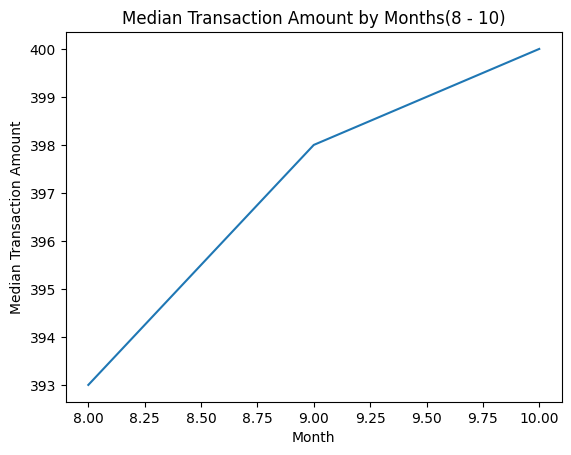

In [368]:
monthly_transactions['TransactionAmount (INR)','median'].plot(kind='line')
plt.title('Median Transaction Amount by Months(8 - 10)')
plt.xlabel('Month')
plt.ylabel('Median Transaction Amount')
plt.show()

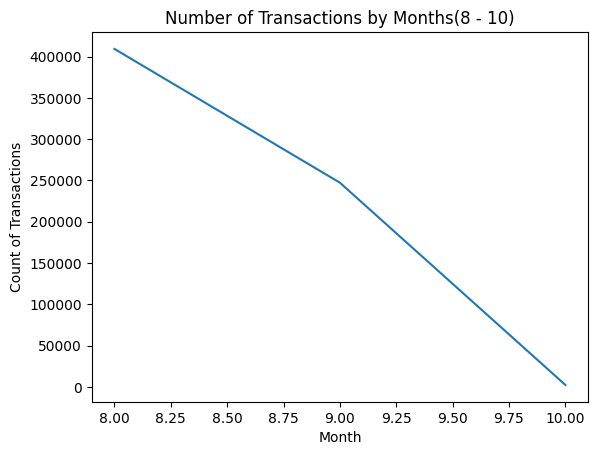

In [369]:
monthly_transactions['TransactionAmount (INR)','count'].plot(kind='line')
plt.title('Number of Transactions by Months(8 - 10)')
plt.xlabel('Month')
plt.ylabel('Count of Transactions')
plt.show()

From these two figures we can conclude that:
* Even though the average of the amount of transaction increase during time
* The number of transaction itself decreases

In [30]:
transactions_num_2 = df[['TransactionAmount (INR)','TransactionHour']]

hourly_transactions = transactions_num_2.groupby('TransactionHour').agg(['median','count'])
hourly_transactions

TransactionAmount (INR)       
                                 median  count
TransactionHour                               
0                               421.500  31373
1                               249.000  15663
2                               400.000  38499
3                               411.650  27989
4                               300.000  23934
5                               428.000  44332
6                               400.000  26866
7                               388.000  36625
8                               454.530  43122
9                               380.000  24132
10                              412.000  45278
11                              400.000  30880
12                              374.000  22375
13                              381.750  39414
14                              315.000  19014
15                              401.000  27880
16                              395.000  27822
17                              345.500  16938
18                              454.000  25396
19                              353.005  10542
20                              355.000  19065
21                              480.000  24548
22                              260.000   8806
23                              374.000  28155

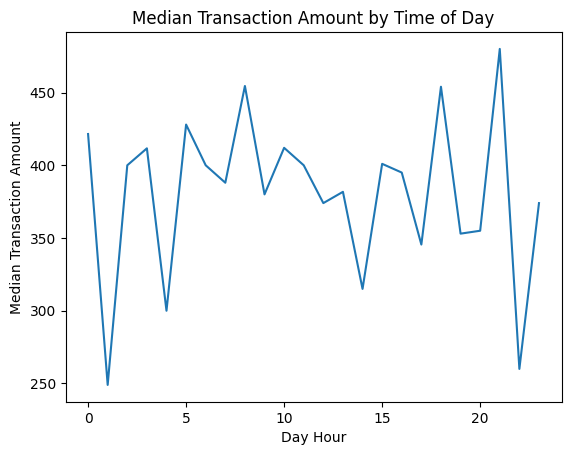

In [371]:
hourly_transactions['TransactionAmount (INR)','median'].plot(kind='line')
plt.title('Median Transaction Amount by Time of Day')
plt.xlabel('Day Hour')
plt.ylabel('Median Transaction Amount')
plt.show()

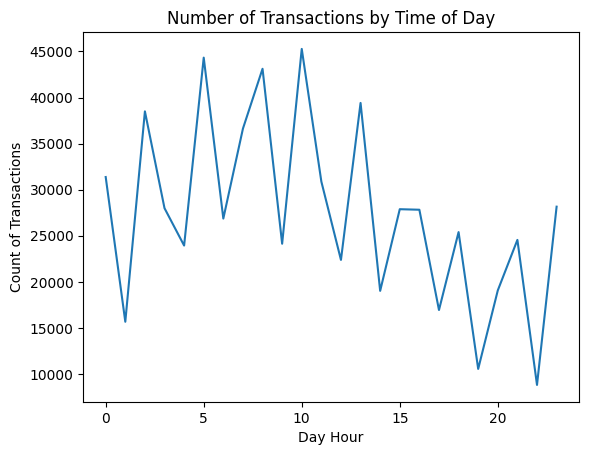

In [372]:
hourly_transactions['TransactionAmount (INR)','count'].plot(kind='line')
plt.title('Number of Transactions by Time of Day')
plt.xlabel('Day Hour')
plt.ylabel('Count of Transactions')
plt.show()

We can notice that the amount of transaction itself decrease with time along the day

In [31]:
transactions_3 = df[['TransactionAmount (INR)','TransactionMonth','TransactionHour']]

monthly_and_hourly = transactions_3.groupby(['TransactionMonth','TransactionHour']).agg(['median','count'])
monthly_and_hourly

TransactionAmount (INR)       
                                                  median  count
TransactionMonth TransactionHour                               
8                0                               420.000  19511
                 1                               249.000  10056
                 2                               400.000  24265
                 3                               410.500  17454
                 4                               300.000  14896
...                                                  ...    ...
10               19                              282.500     70
                 20                              550.000    121
                 21                              357.615    162
                 22                              572.060     20
                 23                              640.000     44

[69 rows x 2 columns]

In [32]:
months = list(range(8,11))
hours = list(range(0,24))

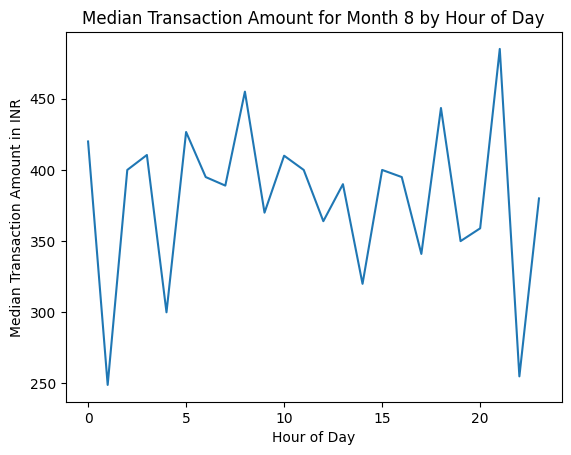

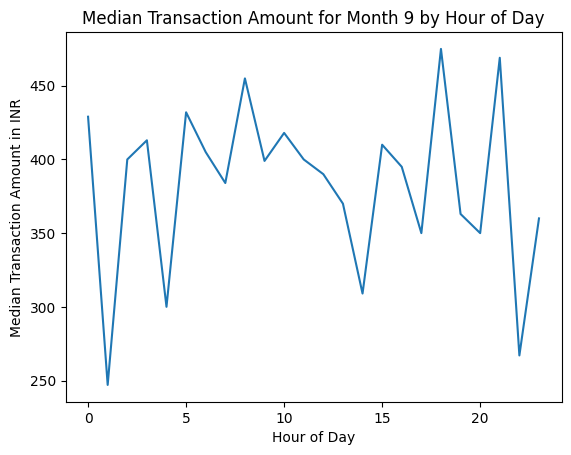

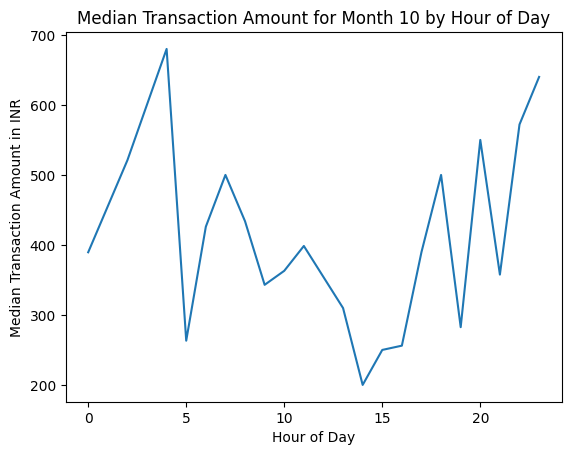

In [375]:
for month in months:
    mini_month = monthly_and_hourly.loc[month]
    mini_month['TransactionAmount (INR)','median'].plot(kind='line')
    plt.title(f'Median Transaction Amount for Month {month} by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Median Transaction Amount in INR')
    plt.show()

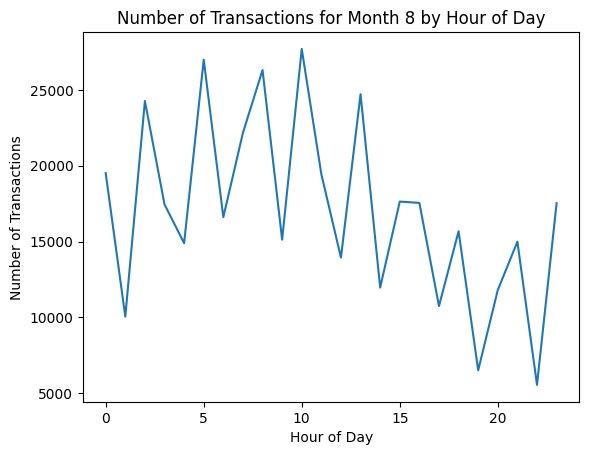

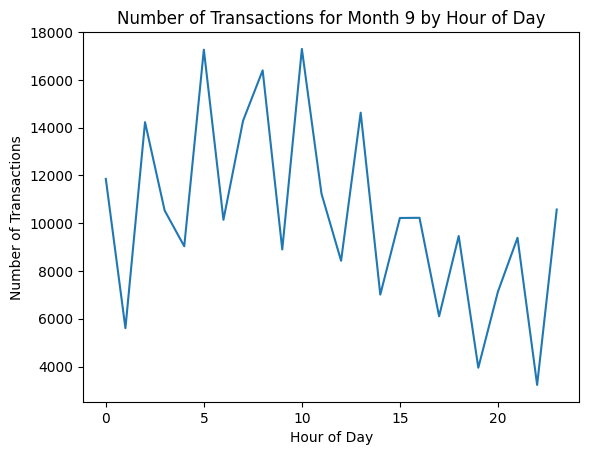

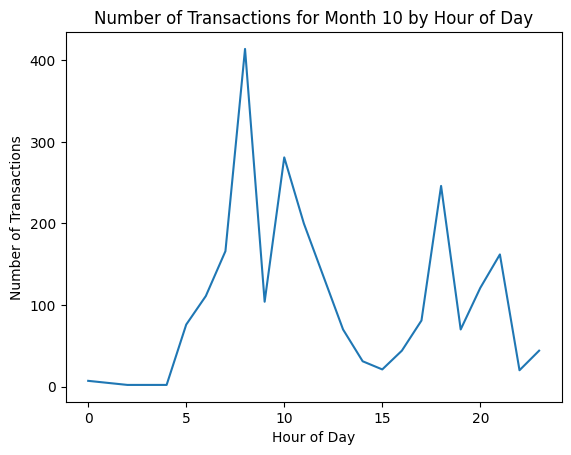

In [376]:
for month in months:
    mini_month = monthly_and_hourly.loc[month]
    mini_month['TransactionAmount (INR)','count'].plot(kind='line')
    plt.title(f'Number of Transactions for Month {month} by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Transactions')
    plt.show()

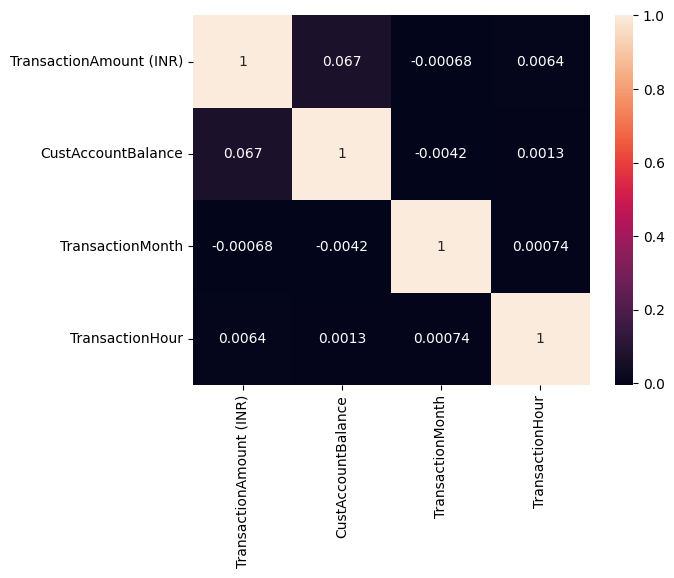

In [377]:
transactions_corr = df[['TransactionAmount (INR)','CustAccountBalance','TransactionMonth','TransactionHour']]

corr_mat = transactions_corr.corr()

sns.heatmap(corr_mat,annot=True)
plt.show()

Owned products column

In [378]:
df.columns

Index(['CustomerID', 'CustomerDOB', 'CustGender', 'CustLocation',
       'CustAccountBalance', 'TransactionDate', 'TransactionTime',
       'TransactionAmount (INR)', 'OwnedProducts', 'CustomerAge',
       'TransactionMonth', 'TransactionYear', 'CustLocation_Cleaned',
       'BalancedCategory', 'TransactionHour', 'TransactionMinute',
       'TransactionSecond'],
      dtype='object')

In [379]:
df['OwnedProducts'].head()

0                   credit card, loans, savings
2                                loans, savings
4                                loans, savings
7    cds, credit card, retirement plan, savings
8                   credit card, loans, savings
Name: OwnedProducts, dtype: object

In [380]:
df['OwnedProducts'].value_counts()

OwnedProducts
loans                                                                           172787
credit card, loans, savings                                                     158198
loans, savings                                                                   88185
credit card, savings                                                             61701
cds, credit card, long term investment, retirement plan, savings, tds            54431
cds, credit card, retirement plan, savings                                       45355
cds, credit card, retirement plan, savings, tds                                  20136
cds, credit card, savings                                                        14629
cds, credit card, long term investment, retirement plan, savings                  9153
cds, credit card, long term investment, savings                                   5102
savings                                                                           3948
credit card, loans           

In [61]:
df['OwnedProducts'].isnull().sum()

2888

In [33]:
#create a colums to count the number of owned products
df['OwnedProductsCount'] = df['OwnedProducts'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
df['OwnedProductsCount'].head()

0    3
2    2
4    2
7    4
8    3
Name: OwnedProductsCount, dtype: int64

We made this column to indicate the no of product each user has and I didn't drop the nulls because I assumed the customer might be new this is the reason why he still doesn't have any product owned

In [34]:
#do one hot encoding for every product alone in owned products
df['OwnedProducts'] = df['OwnedProducts'].fillna('')
df['OwnedProducts'] = df['OwnedProducts'].str.replace(' ', '')
df['OwnedProducts'] = df['OwnedProducts'].str.split(',')

df['OwnedProducts'].head()

0                  [creditcard, loans, savings]
2                              [loans, savings]
4                              [loans, savings]
7    [cds, creditcard, retirementplan, savings]
8                  [creditcard, loans, savings]
Name: OwnedProducts, dtype: object

In [35]:
mlb = MultiLabelBinarizer()
ohe = pd.DataFrame(mlb.fit_transform(df['OwnedProducts']),
                columns=[f'Product_{prod}' for prod in mlb.classes_],
                index=df.index)
ohe.head()

,Product_,Product_cds,Product_creditcard,Product_loans,Product_longterminvestment,Product_retirementplan,Product_savings,Product_tds
0,0,0,1,1,0,0,1,0
2,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,1,0
7,0,1,1,0,0,1,1,0
8,0,0,1,1,0,0,1,0


In [36]:
df = pd.concat([df, ohe], axis=1)

In [41]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),OwnedProducts,...,TransactionSecond,OwnedProductsCount,Product_,Product_cds,Product_creditcard,Product_loans,Product_longterminvestment,Product_retirementplan,Product_savings,Product_tds
0,T1,C5841053,1994-01-10,1,JAMSHEDPUR,17819.05,2016-08-02,15:46:47,25.0,"[creditcard, loans, savings]",...,47,3,0,0,1,1,0,0,1,0
2,T3,C4417068,1996-11-26,1,MUMBAI,17874.44,2016-08-02,15:38:32,459.0,"[loans, savings]",...,32,2,0,0,0,1,0,0,1,0
4,T5,C9031234,1988-03-24,1,NAVI MUMBAI,6714.43,2016-08-02,02:19:16,1762.5,"[loans, savings]",...,16,2,0,0,0,1,0,0,1,0
7,T8,C1220223,1982-01-27,0,MUMBAI,95075.54,2016-08-02,23:22:17,148.0,"[cds, creditcard, retirementplan, savings]",...,17,4,0,1,1,0,0,1,1,0
8,T9,C8536061,1988-04-19,1,GURGAON,14906.96,2016-08-02,05:33:45,833.0,"[creditcard, loans, savings]",...,45,3,0,0,1,1,0,0,1,0


In [37]:
products_count = df[ohe.columns].sum().sort_values(ascending=False)
print(products_count)

Product_savings               473732
Product_loans                 435216
Product_creditcard            381494
Product_cds                   155911
Product_retirementplan        136515
Product_tds                    81019
Product_longterminvestment     75165
Product_                        2888
dtype: int64


Text(0.5, 1.0, 'Distribution of Owned Products')

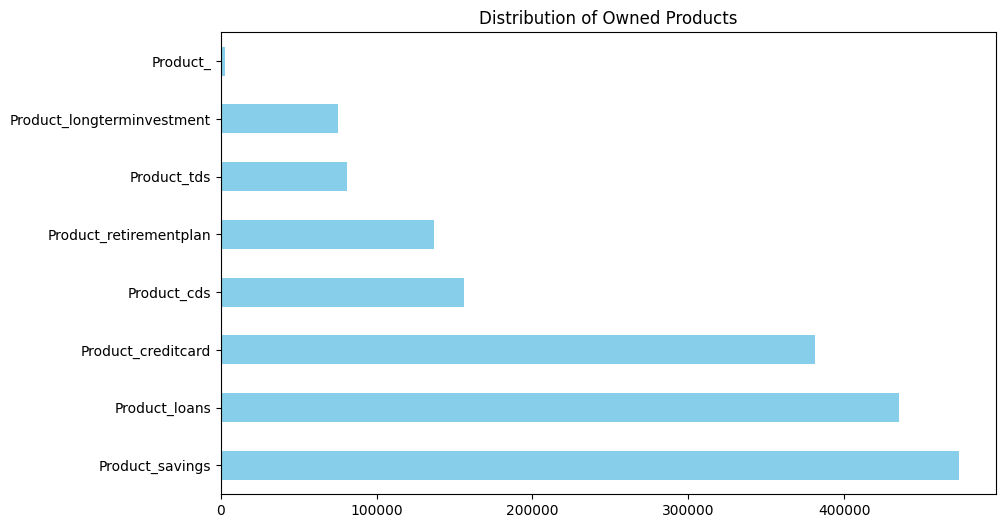

In [38]:
#plot the distribution of the owned products male vertical
products_count.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Distribution of Owned Products')

In general most people use the services related to savings , loans or credit cards

Overall Looking at data

In [61]:
df.drop(columns=['OwnedProducts'], inplace=True)
df.head()

,TransactionID,CustomerID,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR),CustomerAge,TransactionMonth,CustLocation_Cleaned,BalancedCategory,...,Product_,Product_cds,Product_creditcard,Product_loans,Product_longterminvestment,Product_retirementplan,Product_savings,Product_tds,AvgSpent,NumOfTransactions
0,T1,C5841053,1,17819.05,2016-08-02,25.0,31.0,8,JAMSHEDPUR,2,...,0,0,1,1,0,0,1,0,25.0,1
2,T3,C4417068,1,17874.44,2016-08-02,459.0,28.0,8,MUMBAI,2,...,0,0,0,1,0,0,1,0,459.0,1
4,T5,C9031234,1,6714.43,2016-08-02,1762.5,37.0,8,NAVI MUMBAI,1,...,0,0,0,1,0,0,1,0,1762.5,1
7,T8,C1220223,0,95075.54,2016-08-02,148.0,43.0,8,MUMBAI,3,...,0,1,1,0,0,1,1,0,148.0,1
8,T9,C8536061,1,14906.96,2016-08-02,833.0,37.0,8,GURGAON,2,...,0,0,1,1,0,0,1,0,833.0,1


In [39]:
df.drop(columns=['CustomerDOB'], inplace=True)
df.head()

,TransactionID,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),OwnedProducts,CustomerAge,...,TransactionSecond,OwnedProductsCount,Product_,Product_cds,Product_creditcard,Product_loans,Product_longterminvestment,Product_retirementplan,Product_savings,Product_tds
0,T1,C5841053,1,JAMSHEDPUR,17819.05,2016-08-02,15:46:47,25.0,"[creditcard, loans, savings]",31.0,...,47,3,0,0,1,1,0,0,1,0
2,T3,C4417068,1,MUMBAI,17874.44,2016-08-02,15:38:32,459.0,"[loans, savings]",28.0,...,32,2,0,0,0,1,0,0,1,0
4,T5,C9031234,1,NAVI MUMBAI,6714.43,2016-08-02,02:19:16,1762.5,"[loans, savings]",37.0,...,16,2,0,0,0,1,0,0,1,0
7,T8,C1220223,0,MUMBAI,95075.54,2016-08-02,23:22:17,148.0,"[cds, creditcard, retirementplan, savings]",43.0,...,17,4,0,1,1,0,0,1,1,0
8,T9,C8536061,1,GURGAON,14906.96,2016-08-02,05:33:45,833.0,"[creditcard, loans, savings]",37.0,...,45,3,0,0,1,1,0,0,1,0


In [40]:
df.drop(columns=['TransactionYear'], inplace=True)
df.drop(columns=['TransactionSecond'], inplace=True)
df.head()

,TransactionID,CustomerID,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),OwnedProducts,CustomerAge,...,TransactionMinute,OwnedProductsCount,Product_,Product_cds,Product_creditcard,Product_loans,Product_longterminvestment,Product_retirementplan,Product_savings,Product_tds
0,T1,C5841053,1,JAMSHEDPUR,17819.05,2016-08-02,15:46:47,25.0,"[creditcard, loans, savings]",31.0,...,46,3,0,0,1,1,0,0,1,0
2,T3,C4417068,1,MUMBAI,17874.44,2016-08-02,15:38:32,459.0,"[loans, savings]",28.0,...,38,2,0,0,0,1,0,0,1,0
4,T5,C9031234,1,NAVI MUMBAI,6714.43,2016-08-02,02:19:16,1762.5,"[loans, savings]",37.0,...,19,2,0,0,0,1,0,0,1,0
7,T8,C1220223,0,MUMBAI,95075.54,2016-08-02,23:22:17,148.0,"[cds, creditcard, retirementplan, savings]",43.0,...,22,4,0,1,1,0,0,1,1,0
8,T9,C8536061,1,GURGAON,14906.96,2016-08-02,05:33:45,833.0,"[creditcard, loans, savings]",37.0,...,33,3,0,0,1,1,0,0,1,0


In [41]:
df.drop(columns=['TransactionTime'], inplace=True)
df.drop(columns=['CustLocation'], inplace=True)
df.head()

,TransactionID,CustomerID,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR),OwnedProducts,CustomerAge,TransactionMonth,CustLocation_Cleaned,...,TransactionMinute,OwnedProductsCount,Product_,Product_cds,Product_creditcard,Product_loans,Product_longterminvestment,Product_retirementplan,Product_savings,Product_tds
0,T1,C5841053,1,17819.05,2016-08-02,25.0,"[creditcard, loans, savings]",31.0,8,JAMSHEDPUR,...,46,3,0,0,1,1,0,0,1,0
2,T3,C4417068,1,17874.44,2016-08-02,459.0,"[loans, savings]",28.0,8,MUMBAI,...,38,2,0,0,0,1,0,0,1,0
4,T5,C9031234,1,6714.43,2016-08-02,1762.5,"[loans, savings]",37.0,8,NAVI MUMBAI,...,19,2,0,0,0,1,0,0,1,0
7,T8,C1220223,0,95075.54,2016-08-02,148.0,"[cds, creditcard, retirementplan, savings]",43.0,8,MUMBAI,...,22,4,0,1,1,0,0,1,1,0
8,T9,C8536061,1,14906.96,2016-08-02,833.0,"[creditcard, loans, savings]",37.0,8,GURGAON,...,33,3,0,0,1,1,0,0,1,0


In [402]:
df.columns

Index(['CustomerID', 'CustGender', 'CustAccountBalance', 'TransactionDate',
       'TransactionAmount (INR)', 'CustomerAge', 'TransactionMonth',
       'CustLocation_Cleaned', 'BalancedCategory', 'TransactionHour',
       'TransactionMinute', 'OwnedProductsCount', 'Product_', 'Product_cds',
       'Product_creditcard', 'Product_loans', 'Product_longterminvestment',
       'Product_retirementplan', 'Product_savings', 'Product_tds', 'AvgSpent',
       'NumOfTransactions'],
      dtype='object')

# Data Aggregation to Customer Level

In [42]:
#get a column that would be the avg spent by each customer 
df['AvgSpent'] = df.groupby('CustomerID')['TransactionAmount (INR)'].transform('mean')
df['AvgSpent'].head(10)

0        25.00
2       459.00
4      1762.50
7       148.00
8       833.00
9       289.11
11      202.00
12    12300.00
13       50.00
14      338.00
Name: AvgSpent, dtype: float64

In [43]:
#make a column to no the num of transactions for each customer
df['NumOfTransactions'] = df.groupby('CustomerID')['TransactionID'].transform('count')
df['NumOfTransactions'].value_counts()

NumOfTransactions
1    657012
2      1630
3         6
Name: count, dtype: int64

In [44]:
#Customer level using data aggregation and feature engineering
df_customer = df.groupby('CustomerID').agg({
    'CustGender': 'first',
    'CustLocation_Cleaned': 'first',
    'CustAccountBalance': 'first',
    'BalancedCategory' : 'first',
    'BalancedCategory': 'first',
    'TransactionAmount (INR)': 'mean',
    'TransactionMonth': 'mean',
    'NumOfTransactions' : 'count',
    'CustomerAge': 'first',
    **{col: ['sum'] for col in ohe.columns}
}).reset_index()
    

df_customer.columns = ['_'.join(col).strip() for col in df_customer.columns.values]

In [45]:
df_customer.rename(columns={'TransactionAmount (INR)_mean': 'AvgTransactionAmount',
                            'TransactionMonth_mean': 'AvgTransactionMonth',
                            'NumOfTransactions_count': 'TotalTransactions',
                            'CustLocation_Cleaned_first': 'CustLocation',
                            'CustGender_first': 'CustGender',
                            'CustAccountBalance_first': 'CustAccountBalance',
                            'BalancedCategory_first': 'BalancedCategory',
                            'CustomerAge_first': 'CustomerAge',
                            'OwnedProductsCount_sum': 'OwnedProductsCount',
                            
                            }, inplace=True)
df_customer.head()

,CustomerID_,CustGender,CustLocation,CustAccountBalance,BalancedCategory,AvgTransactionAmount,AvgTransactionMonth,TotalTransactions,CustomerAge,Product__sum,Product_cds_sum,Product_creditcard_sum,Product_loans_sum,Product_longterminvestment_sum,Product_retirementplan_sum,Product_savings_sum,Product_tds_sum
0,C1010012,0,MUMBAI,24204.49,2,1499.0,8.0,1,30.0,0,0,1,1,0,0,1,0
1,C1010018,1,CHAMPARAN,496.18,1,30.0,9.0,1,34.0,0,0,0,1,0,0,0,0
2,C1010028,1,DELHI,296828.37,4,557.0,8.0,1,36.0,0,1,1,0,1,1,1,1
3,C1010036,0,GURGAON,355430.17,4,208.0,8.0,1,29.0,0,0,0,0,0,0,1,0
4,C1010037,0,BANGALORE,95859.17,3,19680.0,8.0,1,43.0,0,1,1,0,0,1,1,0


In [46]:
df_customer.drop(columns=['CustomerID_'], inplace=True)

In [47]:
#convert location using Frequency Encoding to map to the number of customers in each location
location_counts = df_customer['CustLocation'].value_counts().to_dict()
df_customer['CustLocation'] = df_customer['CustLocation'].map(location_counts)
df_customer['CustLocation'].head()


0    64473
1      120
2    45444
3    47106
4    52793
Name: CustLocation, dtype: int64

In [469]:
df_customer.head()

,CustGender,CustLocation,CustAccountBalance,BalancedCategory,AvgTransactionAmount,AvgTransactionMonth,TotalTransactions,CustomerAge,Product__sum,Product_cds_sum,Product_creditcard_sum,Product_loans_sum,Product_longterminvestment_sum,Product_retirementplan_sum,Product_savings_sum,Product_tds_sum
0,0,64473,24204.49,2,1499.0,8.0,1,30.0,0,0,1,1,0,0,1,0
1,1,120,496.18,1,30.0,9.0,1,34.0,0,0,0,1,0,0,0,0
2,1,45444,296828.37,4,557.0,8.0,1,36.0,0,1,1,0,1,1,1,1
3,0,47106,355430.17,4,208.0,8.0,1,29.0,0,0,0,0,0,0,1,0
4,0,52793,95859.17,3,19680.0,8.0,1,43.0,0,1,1,0,0,1,1,0


In [79]:
df_customer

,CustGender,CustLocation,CustAccountBalance,BalancedCategory,AvgTransactionAmount,AvgTransactionMonth,TotalTransactions,CustomerAge,Product__sum,Product_cds_sum,Product_creditcard_sum,Product_loans_sum,Product_longterminvestment_sum,Product_retirementplan_sum,Product_savings_sum,Product_tds_sum
0,0,64473,24204.49,2,1499.0,8.0,1,30.0,0,0,1,1,0,0,1,0
1,1,120,496.18,1,30.0,9.0,1,34.0,0,0,0,1,0,0,0,0
2,1,45444,296828.37,4,557.0,8.0,1,36.0,0,1,1,0,1,1,1,1
3,0,47106,355430.17,4,208.0,8.0,1,29.0,0,0,0,0,0,0,1,0
4,0,52793,95859.17,3,19680.0,8.0,1,43.0,0,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657824,0,1435,133067.23,4,691.0,8.0,1,34.0,0,1,1,0,0,1,1,1
657825,0,52793,96063.46,3,222.0,9.0,1,28.0,0,0,0,0,0,0,1,0
657826,0,1867,5559.75,1,126.0,8.0,1,31.0,0,0,0,1,0,0,1,0
657827,0,17483,35295.92,2,50.0,8.0,1,30.0,0,0,1,0,0,0,1,0


In [48]:
num_cols = ['CustAccountBalance', 'AvgTransactionAmount', 'CustomerAge']
cat_cols = ['CustGender', 'BalancedCategory', 'CustLocation']

num_pipeline = Pipeline([
    ('scaler', RobustScaler())  
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])

location_pipeline = Pipeline([
    ('scaler', MinMaxScaler()) 
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols), 
    ('cat', cat_pipeline, cat_cols)   
])

In [49]:
data_processed = preprocessor.fit_transform(df_customer)

In [68]:
#shape bedore
print("Shape before: ", df_customer.shape)

Shape before:  (657829, 16)


In [51]:
#use svd
svd = TruncatedSVD(n_components=16, random_state=42)
data_svd = svd.fit_transform(data_processed)
print("Shape after SVD: ", data_svd.shape)

Shape after SVD:  (657829, 16)


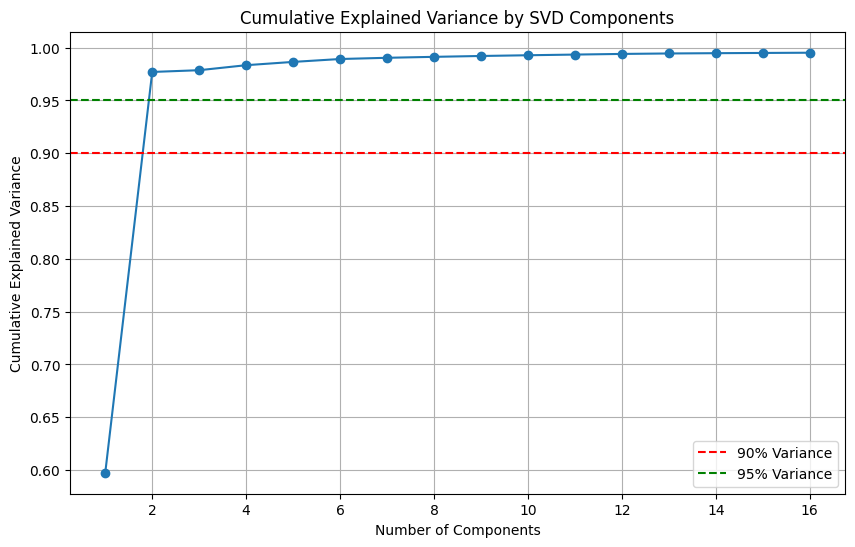

In [53]:
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Variance')
plt.title('Cumulative Explained Variance by SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.show()

In [93]:
#use svd
svd = TruncatedSVD(n_components=3, random_state=42)
data_svd = svd.fit_transform(data_processed)
data_svd = data_svd.astype(np.float16)
print("Shape after SVD: ", data_svd.shape)

Shape after SVD:  (657829, 3)


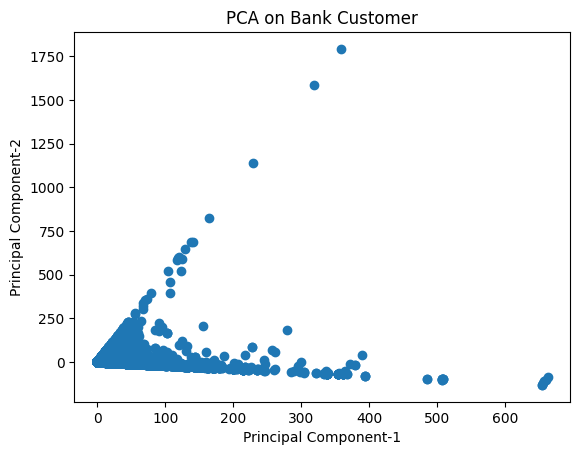

In [60]:
#plot principle components
plt.scatter(data_svd[:,0],data_svd[:,1])
plt.title('PCA on Bank Customer')
plt.xlabel('Principal Component-1')
plt.ylabel('Principal Component-2')
plt.show()

# Modeling

Text(0.5, 1.0, 'Elbow Method for Optimal k')

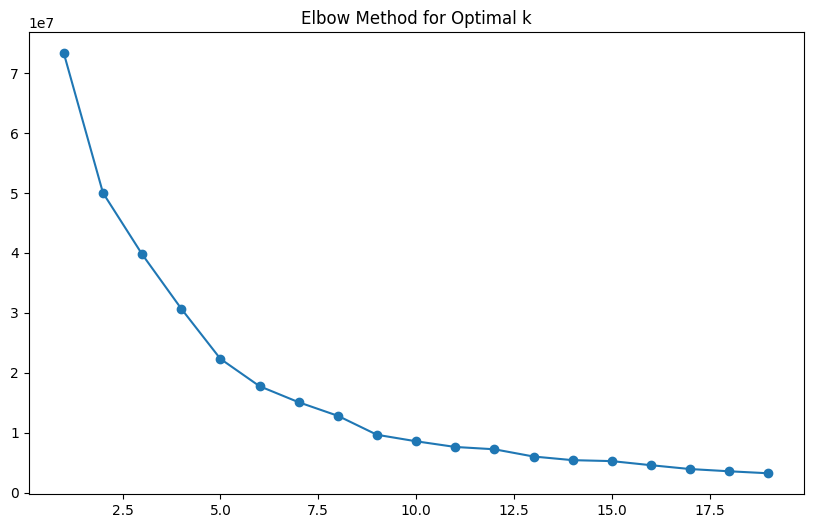

In [91]:
#plot elbow curve
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_svd)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), inertia, marker='o')
plt.title('Elbow Method for Optimal k')

In [94]:
#use kmeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_svd)

KMeans(n_clusters=4, random_state=42)

In [95]:
#calculate silhouette score
data_svd_df = pd.DataFrame(data_svd, columns=[f'Component_{i+1}' for i in range(data_svd.shape[1])])

data_svd_df['Cluster'] = kmeans.labels_
cluster_summary = data_svd_df.groupby('Cluster').mean(numeric_only=True)
print(cluster_summary)

         Component_1  Component_2  Component_3
Cluster                                       
0          25.190592     8.867290     0.198114
1         172.474182   -28.456396    -2.000229
2           0.859858     0.539824     0.941777
3         155.160156   751.671875   -14.330078


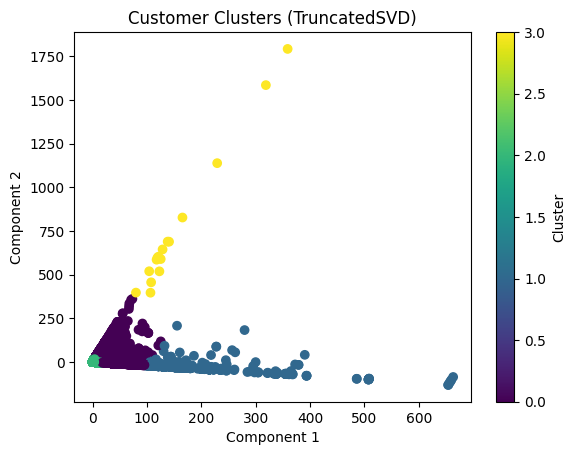

In [95]:
plt.scatter(data_svd[:, 0], data_svd[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Customer Clusters (TruncatedSVD)')
plt.colorbar(label='Cluster')
plt.show()

In [100]:
#evaluation ON SAMPLE using silhouette score
sample = data_svd_df.sample(frac=0.1, random_state=42)
sample_labels = kmeans.labels_[sample.index]

sample_silhouette_score = silhouette_score(sample, sample_labels)
print(f"Silhouette Score on Sample: {sample_silhouette_score}")

Silhouette Score on Sample: 0.8914281194595124


In [101]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(data_svd)

KMeans(n_clusters=5, random_state=42)

In [102]:
#calculate silhouette score
data_svd_df = pd.DataFrame(data_svd, columns=[f'Component_{i+1}' for i in range(data_svd.shape[1])])

data_svd_df['Cluster'] = kmeans.labels_
cluster_summary = data_svd_df.groupby('Cluster').mean(numeric_only=True)
print(cluster_summary)

         Component_1  Component_2  Component_3
Cluster                                       
0          29.379858    -3.622590     0.303336
1         173.559924   -29.075624    -2.013600
2           0.871403     0.557463     0.941970
3         164.035710   802.440579   -15.301684
4          13.724080    48.741230    -0.163550


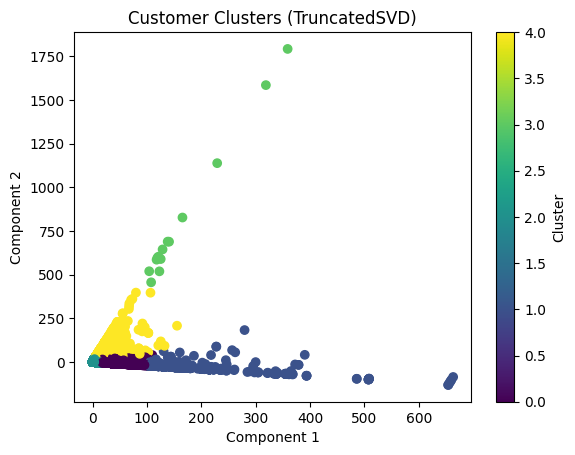

In [103]:
plt.scatter(data_svd[:, 0], data_svd[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Customer Clusters (TruncatedSVD)')
plt.colorbar(label='Cluster')
plt.show()

In [105]:
#evaluation ON SAMPLE using silhouette score
sample = data_svd_df.sample(frac=0.1, random_state=42)
sample_labels = kmeans.labels_[sample.index]

sample_silhouette_score = silhouette_score(sample, sample_labels)
print(f"Silhouette Score on Sample: {sample_silhouette_score}")

Silhouette Score on Sample: 0.8885858240494767


In [116]:
df_customer['Labels'] = kmeans.labels_


labels = [0, 1, 2, 3]  
for label in labels:
    print(f'Cluster no: {label}')
    df_cluster = df_customer[df_customer['Labels'] == label]
    mode_gender = df_cluster['CustGender'].mode()[0] if not df_cluster['CustGender'].mode().empty else None
    mean_accountbalance = df_cluster['CustAccountBalance'].mean()
    mean_transaction_amt = df_cluster['AvgTransactionAmount'].mean()
    mean_customer_age = df_cluster['CustomerAge'].mean()
    
    print(f'Most frequent gender: {mode_gender}')
    print(f'Mean Account Balance: {(mean_accountbalance)}')
    print(f'Mean Transaction Amount (INR): {round(mean_transaction_amt)}')
    print(f'Mean Customer Age: {(mean_customer_age)}')


Cluster no: 0
Most frequent gender: 0
Mean Account Balance: 975751.421207997
Mean Transaction Amount (INR): 12016
Mean Customer Age: 40.55202938696856
Cluster no: 1
Most frequent gender: 0
Mean Account Balance: 7334466.166831551
Mean Transaction Amount (INR): 5459
Mean Customer Age: 41.70989304812834
Cluster no: 2
Most frequent gender: 0
Mean Account Balance: 44775.15055920833
Mean Transaction Amount (INR): 974
Mean Customer Age: 36.96402580024638
Cluster no: 3
Most frequent gender: 0
Mean Account Balance: 218224.19625
Mean Transaction Amount (INR): 655316
Mean Customer Age: 40.8125


In [115]:
df_customer['Cluster'] = kmeans.labels_

cluster_summary = df_customer.groupby('Cluster').mean(numeric_only=True)
print(cluster_summary)

         CustGender  CustLocation  CustAccountBalance  AvgTransactionAmount  \
Cluster                                                                       
0          0.276406  29856.565278        9.757514e+05          12015.572347   
1          0.135027  30824.255348        7.334466e+06           5458.739131   
2          0.277298  23942.881218        4.477515e+04            973.701194   
3          0.312500  30279.812500        2.182242e+05         655315.548750   

         AvgTransactionMonth  TotalTransactions  CustomerAge  Product__sum  \
Cluster                                                                      
0                   8.373178           1.000783    40.552029      0.001024   
1                   8.340909           1.002674    41.709893      0.000000   
2                   8.382505           1.001255    36.964026      0.004483   
3                   8.375000           1.000000    40.812500      0.000000   

         Product_cds_sum  Product_creditcard_sum  Produc

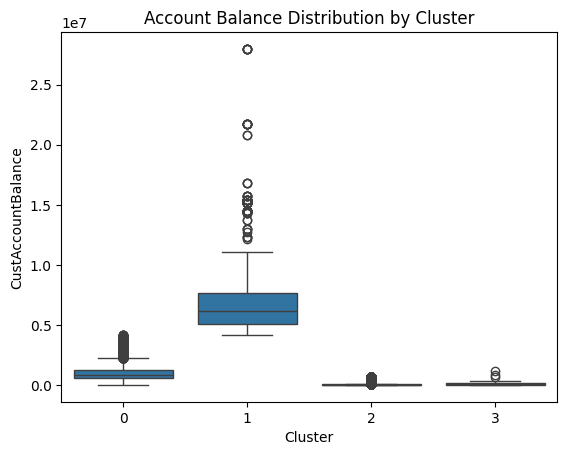

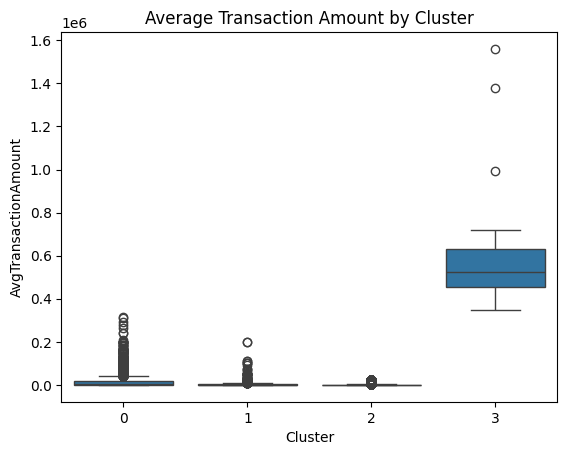

In [117]:
sns.boxplot(x='Cluster', y='CustAccountBalance', data=df_customer)
plt.title("Account Balance Distribution by Cluster")
plt.show()

sns.boxplot(x='Cluster', y='AvgTransactionAmount', data=df_customer)
plt.title("Average Transaction Amount by Cluster")
plt.show()

In [98]:
#final evaluation 
X_sample, labels_sample = resample(data_svd, kmeans.labels_, n_samples=100000, random_state=42)

with tqdm(total=1, desc="Calculating Silhouette Score") as pbar:
    silhouette_avg = silhouette_score(X_sample, labels_sample)
    pbar.update(1) 


print(f"Silhouette Score: {silhouette_avg}")

Calculating Silhouette Score: 100%|██████████| 1/1 [07:33<00:00, 453.12s/it]


Silhouette Score: 0.8915016861507455


Also here I used a sample for evaluation because the whole data took so ling time and eventually had a result close to the sampled one

From these reports and figures we can conclude that :
* Cluster 1 : People in this cluster have the biggest net balance indicating they're in higher level 
* Cluster 3 : People here have the highest rate of transaction amount and the avg of their balance is also moderate
* Cluster 2 : People there considered the least in the net balnce and amount of tansactions also they're the youngest age group

Based on the elbow method technique we were able to take k values as 4 or 5 but after plotting:
* The k = 4 gives better Silhouette Score compared to other also clusters are more distingushable
* The k = 5 even though the difference in score is not a big deal but I feel it's clustered better

Deep Scan

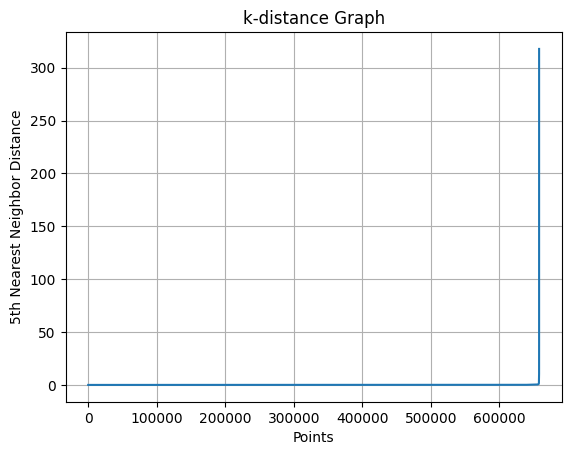

In [61]:
#use deepscan
#k-distance plot 

neigh = NearestNeighbors(n_neighbors=5)
neighbs = neigh.fit(data_svd)
distances, indices = neighbs.kneighbors(data_svd)

distances = np.sort(distances, axis=0)[:, 1]
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('5th Nearest Neighbor Distance')
plt.title('k-distance Graph')
plt.grid(True)
plt.show()

For the Deepscan based on the fact that it crashes the sysytem every single time , I had to dwal with sample or I will try to use anther approach which is more optimized for large datasets

In [ ]:
min_samples = 5
eps = 3

sample_indices = np.random.choice(data_svd.shape[0], size=100000, replace=False)
sample_data = data_svd[sample_indices]

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(sample_data)

df_customer['DBSCAN_Labels'] = -1
df_customer.loc[sample_indices, 'DBSCAN_Labels'] = dbscan.labels_

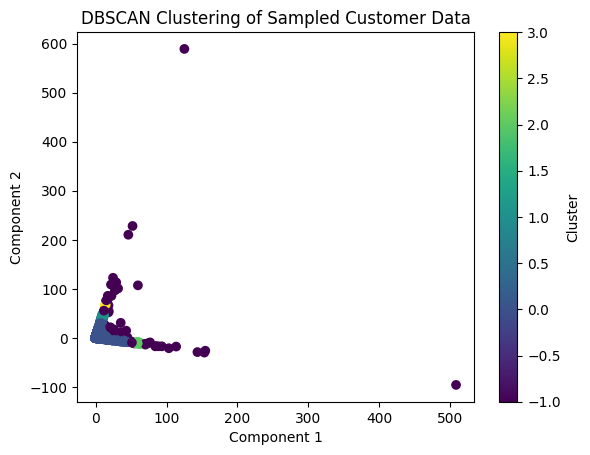

In [61]:
plt.scatter(sample_data[:, 0], sample_data[:, 1], c=dbscan.labels_, cmap='viridis')
plt.title("DBSCAN Clustering of Sampled Customer Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [63]:
valid_labels = dbscan.labels_ != -1
if valid_labels.sum() > 1:  # Ensure there are at least two clusters
    sil_score = silhouette_score(sample_data[valid_labels], dbscan.labels_[valid_labels])
    print(f"Silhouette Score: {sil_score}")
else:
    print("Silhouette Score cannot be calculated as there are less than two clusters.")

Silhouette Score: 0.9116499208573635


HDBSCAN

In [64]:
! pip install hdbscan


     ------------------------------------ 732.2/732.2 kB 633.3 kB/s eta 0:00:00


ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'C:\\Python311\\dist_metrics.pxd'
Consider using the `--user` option or check the permissions.



In [69]:
#use hdbscan
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=3000, min_samples=50, metric='euclidean')
hdbscan_labels = hdbscan_clusterer.fit_predict(data_svd)

df_customer['HDBSCAN_Labels'] = hdbscan_labels

c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [71]:
valid_labels = hdbscan_labels != -1
if valid_labels.sum() > 1:  # Ensure there are at least two clusters
    sil_score = silhouette_score(data_svd[valid_labels], hdbscan_labels[valid_labels])
    print(f"Silhouette Score: {sil_score}")
else:
    print("Silhouette Score cannot be calculated as there are less than two clusters.")

Silhouette Score: 0.4903025078187875


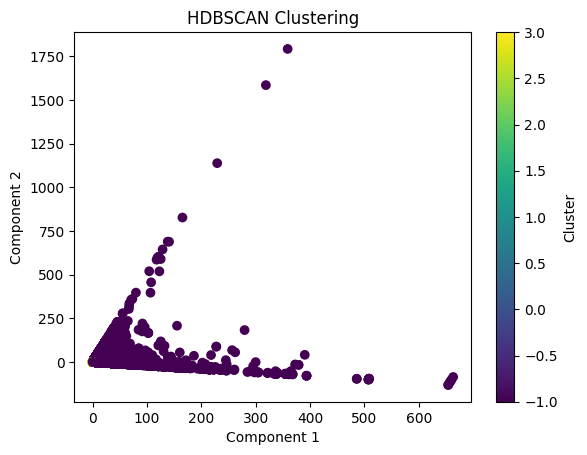

In [70]:
plt.scatter(data_svd[:, 0], data_svd[:, 1], c=hdbscan_labels, cmap='viridis')
plt.title("HDBSCAN Clustering")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.show()

Based on the graph and the scoring we can conclude that:
* HDBSCAN struggled to identify meaningful clusters in the dataset maybe because high dimensionality of data or outliers

GMM

Text(0.5, 1.0, 'BIC Scores for GMM')

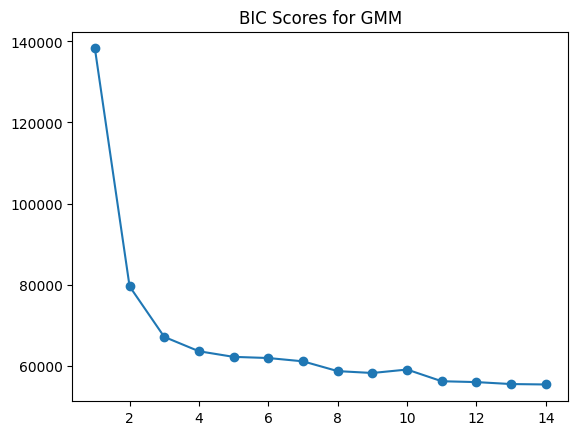

In [72]:
#use gmm
sample_indices = np.random.choice(data_svd.shape[0], size=10000, replace=False)
sample_data = data_svd[sample_indices]

bic_scores = []
n_components_range = range(1, 15)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(sample_data)
    bic_scores.append(gmm.bic(sample_data))

plt.plot(n_components_range, bic_scores, marker='o')
plt.title("BIC Scores for GMM")

In [74]:
gmm = GaussianMixture(n_components=3, random_state=42)
labels = gmm.fit_predict(sample_data)

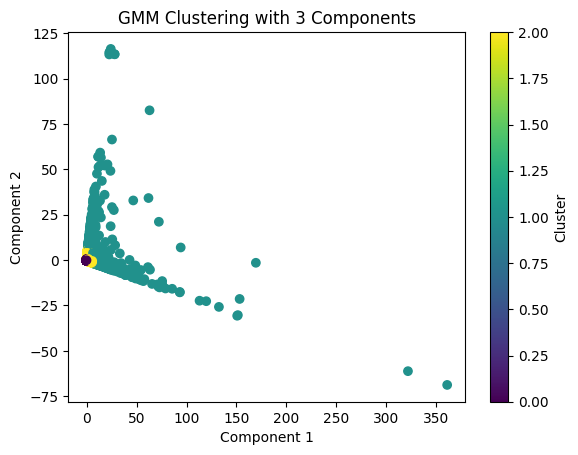

In [75]:
plt.scatter(sample_data[:, 0], sample_data[:, 1], c=labels, cmap='viridis')
plt.title("GMM Clustering with 3 Components")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [76]:
silhouette_avg = silhouette_score(sample_data, labels)
print(f"Silhouette Score for GMM with 3 components: {silhouette_avg}")

Silhouette Score for GMM with 3 components: 0.36290696693330227


Based on all these models and all these results :
* We will use K means model for clustring since it provide the best result
* I wasn't able to use Gmm and DeepScan on all data so I had to work with samples

# Bonus : Build a recommendation system

In [64]:
len(df)

658648

In [69]:
df_customer['cluster'] = -1
df_customer['cluster'] = kmeans.labels_

product_columns = [
    'Product__sum', 'Product_cds_sum', 'Product_creditcard_sum', 'Product_loans_sum',
    'Product_longterminvestment_sum', 'Product_retirementplan_sum', 
    'Product_savings_sum', 'Product_tds_sum'
]

cluster_profiles = df_customer.groupby('cluster')[product_columns].mean()
cluster_profiles

,Product__sum,Product_cds_sum,Product_creditcard_sum,Product_loans_sum,Product_longterminvestment_sum,Product_retirementplan_sum,Product_savings_sum,Product_tds_sum
cluster,,,,,,,,
0,0.001024,0.890461,0.950801,0.079188,0.643502,0.840720,0.969168,0.794412
1,0.000000,0.991979,0.994652,0.006684,0.717914,0.910428,1.001337,0.909091
2,0.004483,0.219179,0.569819,0.677467,0.099832,0.190281,0.713354,0.104836
3,0.000000,0.437500,0.937500,0.375000,0.250000,0.375000,0.937500,0.250000


We can notice that here :
* in cluster 0 : the main adoption or preference for credit_card and saving
* in cluster 1 : the main adoption or preference for cds and saving credit_card
* in cluster 2 : the main adoption or preference for loans and saving saving
* in cluster 3 : the main adoption or preference for credit_card and saving 

In [81]:
#recommend product based n the cluster the user belong to 
def recommend_products(customer_row, cluster_profiles, model, preprocessor):

    if isinstance(customer_row, pd.Series):
        customer_row = pd.DataFrame([customer_row])

    processed = preprocessor.transform(customer_row)
    reduced = svd.transform(processed)

    cluster = model.predict(reduced)[0]

    top_products = cluster_profiles.loc[cluster].sort_values(ascending=False).head(2).index.tolist()

    return top_products

In [ ]:
required_columns = num_cols + cat_cols
sample_customer = df_customer.iloc[10][required_columns]

recommendations = recommend_products(sample_customer, cluster_profiles, kmeans, preprocessor)
print("Recommended Products:", recommendations)

Recommended Products: ['Product_savings_sum', 'Product_loans_sum']


So, We can say that this customer belong to cluster 2 

In [86]:
#add enhancement to the recommendation system to be personalized based on age and account balance
def recommend_products_enhanced(customer_row, cluster_profiles, model, preprocessor, svd):
    if isinstance(customer_row, pd.Series):
        customer_row = pd.DataFrame([customer_row])

    processed = preprocessor.transform(customer_row)
    reduced = svd.transform(processed)

    cluster = model.predict(reduced)[0]

    cluster_products = cluster_profiles.loc[cluster].sort_values(ascending=False)

    customer_age = customer_row['CustomerAge'].values[0]
    customer_balance = customer_row['CustAccountBalance'].values[0]
    print('Customer Age :' , customer_age)
    print('Customer Account balance : ',customer_balance )

    if customer_age < 30:
        prioritized_products = ['Product_savings_sum', 'Product_creditcard_sum']
    elif customer_age >= 30 and customer_age < 60:
        prioritized_products = ['Product_loans_sum', 'Product_retirementplan_sum']
    else:
        prioritized_products = ['Product_longterminvestment_sum', 'Product_retirementplan_sum']

    if customer_balance < 50000:
        prioritized_products.insert(0, 'Product_savings_sum')
    elif customer_balance > 500000:
        prioritized_products.insert(0, 'Product_longterminvestment_sum')

    personalized_recommendations = [
        product for product in prioritized_products if product in cluster_products.index
    ]
    personalized_recommendations += [
        product for product in cluster_products.index if product not in personalized_recommendations
    ]

    return personalized_recommendations[:2]    

In [88]:
required_columns = num_cols + cat_cols
sample_customer = df_customer.iloc[50][required_columns]

recommendations = recommend_products_enhanced(sample_customer, cluster_profiles, kmeans, preprocessor, svd)
print("Personalized Recommended Products:", recommendations)

Customer Age : 33.0
Customer Account balance :  30721.16
Personalized Recommended Products: ['Product_savings_sum', 'Product_loans_sum']


In [91]:
required_columns = num_cols + cat_cols
sample_customer = df_customer.iloc[1500][required_columns]

recommendations = recommend_products_enhanced(sample_customer, cluster_profiles, kmeans, preprocessor, svd)
print("Personalized Recommended Products:", recommendations)

Customer Age : 46.0
Customer Account balance :  210528.66
Personalized Recommended Products: ['Product_loans_sum', 'Product_retirementplan_sum']
